In [1562]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

In [1563]:
usd_rate = pd.read_excel('kurs_valut.xlsx')
brent_oil = pd.read_excel ('oil_data.xlsx') 

usd_rate.head()

,nominal,data,curs,cdx
0,1,2017-11-01,58.1179,Доллар США
1,1,2017-11-02,58.1557,Доллар США
2,1,2017-11-03,58.0869,Доллар США
3,1,2017-11-04,58.4296,Доллар США
4,1,2017-11-08,58.4557,Доллар США


**Отобразим цены на Доллар США**

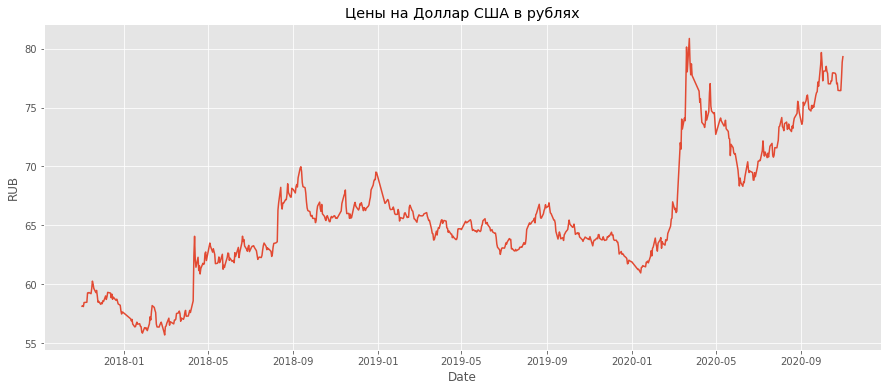

In [1564]:
plt.figure(figsize=(15,6))
plt.style.use('ggplot')
plt.plot(usd_rate.data,usd_rate.curs)
plt.xlabel('Date')
plt.ylabel('RUB')
plt.title('Цены на Доллар США в рублях')
plt.show()

**Отобразим цены на баррель нефти**

In [1565]:
brent_oil.columns = ['data', 'price']
brent_oil.drop(brent_oil.index[:1], inplace=True)
brent_oil['data'] = pd.to_datetime(brent_oil['data']).dt.date
brent_oil.head()

,data,price
1,1987-05-20,18.63
2,1987-05-21,18.45
3,1987-05-22,18.55
4,1987-05-25,18.6
5,1987-05-26,18.63


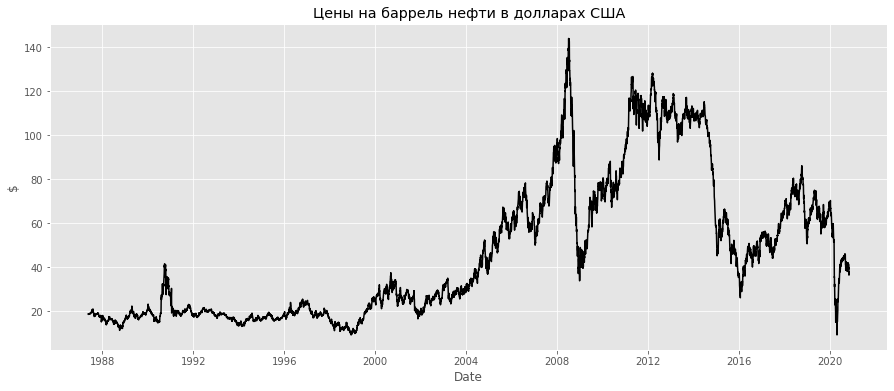

In [1566]:
plt.figure(figsize=(15,6))
plt.style.use('ggplot')
plt.plot(brent_oil.data,brent_oil.price, color='Black')
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Цены на баррель нефти в долларах США')
plt.show()

**Выявление дополнительных фичей, влияющих на курс доллара**

In [1567]:
from sklearn.preprocessing import StandardScaler # Нормировка данных

X = usd_rate[['curs']].values
X_std = StandardScaler().fit_transform(X)

In [1568]:
from sklearn.cluster import KMeans

# Подберем количество кластеров
n_cluster = range(1, 20)

k_means = [KMeans(n_clusters=i).fit(X_std) for i in n_cluster]
scores = [k_means[i].score(X_std) for i in range(len(k_means))]

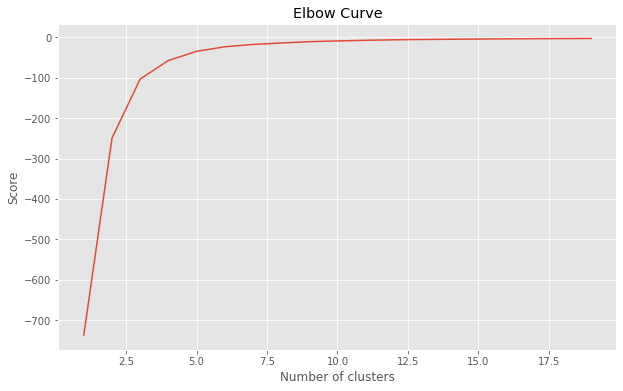

In [1569]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

График начинает выравниваться после 7 кластера. Возьмем 10 кластеров для обучения модели

In [1570]:
km = KMeans(n_clusters=10, random_state=42)
km.fit(X_std)
km.predict(X_std)
labels = km.labels_

k-means создает k похожих кластеров точек данных. Экземпляры данных, которые не входят в эти группы, м.б. отмечены как аномалии.

In [1571]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0, len(usd_rate)):
        Xa = X_std[i]
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.loc[i] = np.linalg.norm(Xa-Xb)
    
    return distance

outliers_fraction = 0.2
# Расстояние между каждой точкой и ее ближайшим центроидом. Самые большие расстояния считаются аномалией
distance = getDistanceByPoint(X_std, k_means[9])

number_of_outliers = int(outliers_fraction*len(distance))

threshold = distance.nlargest(number_of_outliers).min()

usd_rate['anomaly'] = (distance >= threshold).astype(int)

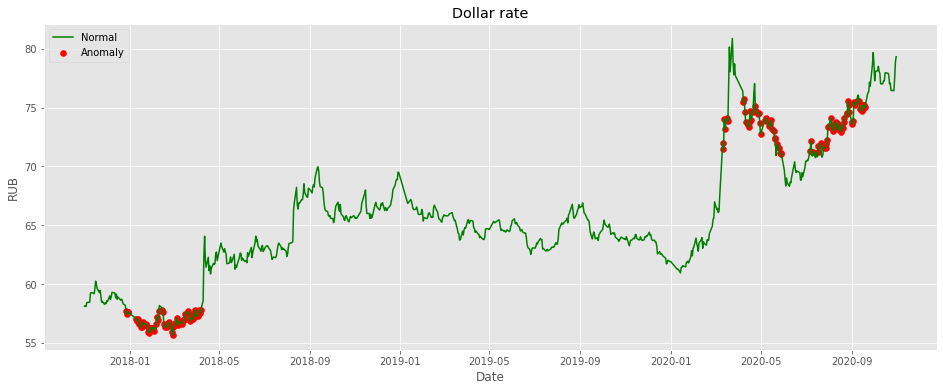

In [1572]:
usd_rate = usd_rate.sort_values('data')

fig, ax = plt.subplots(figsize=(16,6))
plt.title('Dollar rate')
a = usd_rate.loc[usd_rate['anomaly'] == 1, ['data', 'curs']] # Аномалия

ax.plot(usd_rate['data'], usd_rate['curs'], color='green', label='Normal')
ax.scatter(a['data'], a['curs'], color='red', label='Anomaly')

plt.xlabel('Date')
plt.ylabel('RUB')
plt.legend()
plt.show()

На графике имеются аномалии, влияющие на курс доллара. Сопоставим с графиком цены на нефть.

<Figure size 1152x432 with 0 Axes>

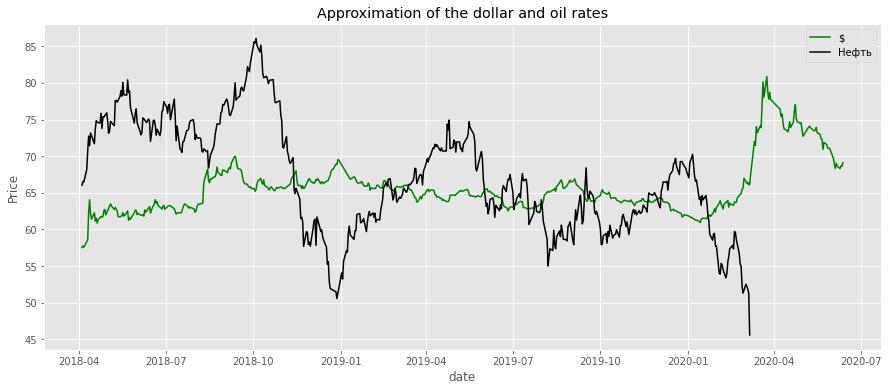

In [1573]:
plt.figure(figsize=(16,6))

fig,ax = plt.subplots(figsize=(15,6))

plt.title('Approximation of the dollar and oil rates')

a = usd_rate.loc[usd_rate['anomaly'] == 1, ['data', 'curs']]

ax.plot(usd_rate['data'][100:-100], usd_rate['curs'][100:-100], color='green', label='$')
ax.plot(brent_oil.data[7836:-166], brent_oil.price[7836:-166], color='black', label='Нефть')

plt.xlabel('date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [1574]:
df = usd_rate.set_index('data').join(brent_oil.set_index('data')).reset_index()
df.price.isna().count() # Пустые значения

737

In [1575]:
# Заполним пропуски такими же ценами, т.к. цена не менялась (биржа не работала)
df = df.fillna(method='ffill')

In [1576]:
df

,data,nominal,curs,cdx,anomaly,price
0,2017-11-01,1,58.1179,Доллар США,0,60.98
1,2017-11-02,1,58.1557,Доллар США,0,60.79
2,2017-11-03,1,58.0869,Доллар США,0,61.42
3,2017-11-04,1,58.4296,Доллар США,0,61.42
4,2017-11-08,1,58.4557,Доллар США,0,63.96
...,...,...,...,...,...,...
732,2020-10-27,1,76.4443,Доллар США,0,39.72
733,2020-10-28,1,76.4556,Доллар США,0,37.86
734,2020-10-29,1,77.5520,Доллар США,0,36.56
735,2020-10-30,1,78.8699,Доллар США,0,36.33


In [1577]:
df = df.drop(['nominal', 'cdx'], axis=1) # Избавимся от лишних колонок
df.columns = ['Date', 'Dollar', 'Anomaly', 'Nafta']

**Построим корреляцию**

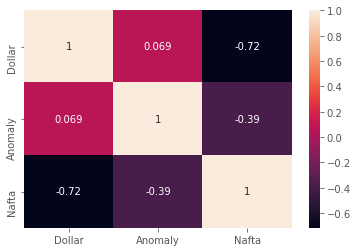

In [1578]:
import seaborn as sn

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Отсутствие прямой зависимости курса доллара от цены нефти из-за влияния мн-ва других факторов

**Генерация признаков**

In [1579]:
pd.to_datetime(df['Date'], infer_datetime_format=True)
df.head(1)

,Date,Dollar,Anomaly,Nafta
0,2017-11-01,58.1179,0,60.98


In [1580]:
# Создадим новые колонки
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [1581]:
past_days = 7 # Период оценки для модели
# Создаем цикл, в котором будут последовательно вноситься курс доллара и цена за баррель нефти в течении 7 прошлых дней
for day in range(1, past_days): 
    df[f"day_lag_{day}"] = df['Dollar'].shift(day)
    df[f"oil_lag_{day}"] = df['Nafta'].shift(day)
    df[f"mult_{day}"] = df[f"day_lag_{day}"] * df[f"oil_lag_{day}"] # Произведение рассматриваемых показателей
    
# Cреднее значение показателей за неделю
df['usd_mean_week'] = df['Dollar'].rolling(window=7).mean()
df['oil_mean_week'] = df['Nafta'].rolling(window=7).mean()

df = pd.get_dummies(df, columns=['year', 'month', 'day'])
df = df[7:]

In [1582]:
X = df.drop(['Date', 'Dollar'], axis=1)

y = df.Dollar

In [1583]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1584]:
from sklearn.preprocessing import StandardScaler # Использование стандартизации

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)
X_test_scal

array([[-0.49249689, -0.04179347, -0.13114706, ..., -0.20248017,
        -0.20248017, -0.14484136],
       [-0.49249689,  0.95859448, -0.4900479 , ..., -0.20248017,
        -0.20248017, -0.14484136],
       [-0.49249689,  0.17213032, -0.04487501, ..., -0.20248017,
        -0.20248017, -0.14484136],
       ...,
       [-0.49249689,  1.79282804, -0.04398327, ..., -0.20248017,
        -0.20248017, -0.14484136],
       [-0.49249689,  0.93436363, -0.73871328, ..., -0.20248017,
        -0.20248017, -0.14484136],
       [-0.49249689, -0.1401015 ,  0.21272684, ..., -0.20248017,
         4.93875534, -0.14484136]])

**Линейная регрессия**

In [1585]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_scal, y_train)

LinearRegression(normalize=True)

In [1586]:
prediction = lin_reg.predict(X_test_scal)
prediction[:10]

array([65.03  , 62.9497, 65.5691, 63.786 , 63.5653, 66.9227, 56.4334,
       57.4942, 62.2056, 65.1639])

<Figure size 1152x432 with 0 Axes>

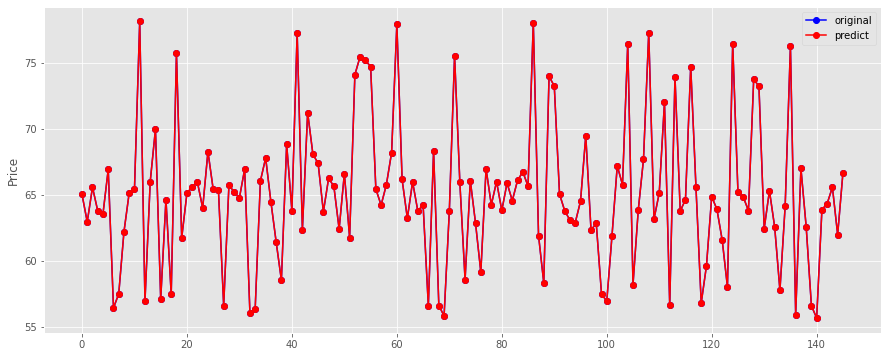

In [1587]:
plt.figure(figsize=(16,6))

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(y_test.values, color='blue', label='original', marker='o')
ax.plot(prediction, color='red', label='predict', marker='o')

plt.ylabel('Price')
plt.legend()
plt.show()


In [1588]:
from sklearn.metrics import mean_absolute_error
print('Ошибается на' + ' ' + str(mean_absolute_error(y_test, prediction))+ ' рублей')

Ошибается на 1.0069266577312653e-13 рублей


In [1589]:
print('Точность модели' + ' ' + str(lin_reg.score(X_test_scal, y_test)*100)+ ' %')

Точность модели 100.0 %


In [1590]:
pd.DataFrame(data=lin_reg.coef_, index=X_train.columns).sort_values(0, ascending=False)

,0
usd_mean_week,36.357735
year_2018,0.306693
year_2019,0.306278
year_2020,0.298494
year_2017,0.144313
...,...
day_lag_5,-5.195817
day_lag_4,-5.213585
day_lag_3,-5.244366
day_lag_2,-5.266710


На графике видим совпадение предсказанной выборки с реальными данными - пробуем другие модели

**Random Forest**

In [1591]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=200, criterion='mae', random_state=42)
rfr.fit(X_train_scal, y_train)
prediction2 = rfr.predict(X_test_scal)

In [1592]:
print('Ошибается на' + ' ' + str(mean_absolute_error(y_test, prediction2))+ ' рублей')

Ошибается на 0.3847482174657562 рублей


In [1593]:
print('Точность модели' + ' ' + str(rfr.score(X_test_scal, y_test)*100)+ ' %')

Точность модели 98.86704019410338 %


**Lasso**

In [1594]:
from sklearn.linear_model import LassoLarsCV

llcv = LassoLarsCV(normalize=True)
llcv.fit(X_train_scal, y_train)
prediction3 = llcv.predict(X_test_scal)

In [1595]:
print('Ошибается на' + ' ' + str(mean_absolute_error(y_test, prediction3))+ ' рублей')

Ошибается на 2.1932750897040894e-11 рублей


In [1596]:
print('Точность модели' + ' ' + str(llcv.score(X_test_scal, y_test)*100)+ ' %')

Точность модели 100.0 %


In [1597]:
pd.DataFrame(data=llcv.coef_, index=X_train.columns).sort_values(0, ascending=False)

,0
usd_mean_week,3.635774e+01
mult_3,2.488632e-11
mult_6,6.174215e-12
month_8,3.331607e-12
day_29,2.879995e-12
...,...
day_lag_5,-5.195817e+00
day_lag_4,-5.213585e+00
day_lag_3,-5.244366e+00
day_lag_2,-5.266710e+00


Заметим, что аномалии имеют вес в обучении алгоритма

**K-neighbors**

In [1598]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_scal, y_train)
prediction4 = knn.predict(X_test_scal)

In [1599]:
print('Ошибается на' + ' ' + str(mean_absolute_error(y_test, prediction4))+ ' рублей')

Ошибается на 1.7623340410958912 рублей


In [1600]:
print('Точность модели' + ' ' + str(knn.score(X_test_scal, y_test)*100)+ ' %')

Точность модели 81.00555823935301 %


In [1601]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(200,200,200), 
                   max_iter=2000, random_state=42)
mlp.fit(X_train_scal, y_train)
prediction5 = mlp.predict(X_test_scal)

In [1602]:
print('Ошибается на' + ' ' + str(mean_absolute_error(y_test, prediction5))+ ' рублей')

Ошибается на 0.7207013431433128 рублей


In [1603]:
print('Точность модели' + ' ' + str(mlp.score(X_test_scal, y_test)*100)+ ' %')

Точность модели 96.83327323841252 %


**Выбор алгоритмов**

In [1604]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

In [1605]:
models = []
names = ['LinearRegression', 'KNeighborsRegressor', 'BaggingRegressor', 
         'GradientBoostingRegressor', 'RandomForestRegressor', 'AdaBoostRegressor']

models.append(LinearRegression(n_jobs=-1))
models.append(KNeighborsRegressor(n_jobs=-1))
models.append(BaggingRegressor())
models.append(GradientBoostingRegressor())
models.append(RandomForestRegressor())
models.append(AdaBoostRegressor())

In [1606]:
params = {
    models[0] : {'normalize': ['True', 'False'], 'fit_intercept' : ['True', 'False']},
    models[1] : {'n_neighbors' : list(range(1, 20)), 'weights' : ['uniform', 'distance']},
    models[2] : {'n_estimators' : list(range(1, 20))},
    models[3] : {'loss' : ['ls', 'lad', 'huber'], 'learning_rate' : [0, 0.1, 0.03, 0.5], 
                 'max_depth' : list(range(1,20))},
    models[4] : {'n_estimators' : list(range(10,20)), 'max_depth' : list(range(1, 20))},
    models[5] : {'learning_rate': list(np.arange(0.0, 1.0, 0.1)), 'loss': ['linear', 
                                                                          'square', 'exponential']},
    
} # Подбор параметров

In [1607]:
from sklearn.model_selection import GridSearchCV

from warnings import filterwarnings
filterwarnings('ignore')

for name, model in zip(names, models):
    grid = GridSearchCV(estimator=model,param_grid=params[model], cv=5, n_jobs=-1)
    grid.fit(X_train_scal, y_train)
    if grid.best_score_ != 1.0:
        print('_________________________________________')
        print('Алгоритм:   ' + str(grid.best_estimator_))
        print('Лучшие параметры: ' + str(grid.best_params_))
        print('Лучшая оценка:   ' + str(grid.best_score_))
        print('_________________________________________')
    

_________________________________________
Алгоритм:   KNeighborsRegressor(n_jobs=-1, n_neighbors=19)
Лучшие параметры: {'n_neighbors': 19, 'weights': 'uniform'}
Лучшая оценка:   0.8971224763363089
_________________________________________
_________________________________________
Алгоритм:   BaggingRegressor(n_estimators=19)
Лучшие параметры: {'n_estimators': 19}
Лучшая оценка:   0.9872415197785072
_________________________________________
_________________________________________
Алгоритм:   GradientBoostingRegressor()
Лучшие параметры: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3}
Лучшая оценка:   0.98724335904034
_________________________________________
_________________________________________
Алгоритм:   RandomForestRegressor(max_depth=12, n_estimators=11)
Лучшие параметры: {'max_depth': 12, 'n_estimators': 11}
Лучшая оценка:   0.987880348592228
_________________________________________
_________________________________________
Алгоритм:   AdaBoostRegressor(learning_rate=0

**Вывод: Не смотря на то, что регрессионные модели неплохо справляются с текущей задачей, в реальных условиях торговли лучше всего использовать модели, учитывающие сезонность, тренд и цикличность.**